Q1

a. The erosion of set A can lie completely or partially outside A if the structuring element used for erosion extends beyond the boundaries of A. if the structuring element extends beyond the boundary of A, erosion can cause parts of A to be eroded and lie outside the resulting set. This can happen when the structuring element is larger than the gaps or thin regions within A, causing erosion to extend beyond those regions.

b. The Fast Fourier Transform (FFT) algorithm can reduce the time complexity of morphological dilation and erosion operations. Using FFT, the time complexity depends only on the image size. 

Convert the binary image and structuring element to frequency domain using FFT.
Multiply the frequency domain representations for dilation or convolve them for erosion.
Perform inverse FFT to obtain the result in the spatial domain.

Using FFT improves efficiency by reducing the time complexity, primarily dependent on the image size (O(N log N)). The structuring element size has a lesser impact on time complexity.

Q2

Answered in pdf

Q3

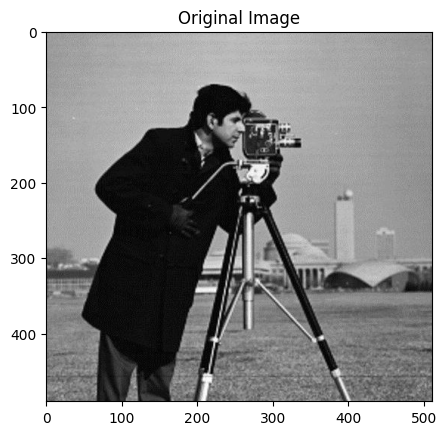

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from PIL import Image

image = Image.open('cameraman.jpg').convert('L')
image = np.array(image)

plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

In [29]:
def walsh_hadamard_transform(block):
    N = block.shape[0]
    H = generate_hadamard_matrix(N)
    return H @ block @ H

def inverse_walsh_hadamard_transform(block):
    N = block.shape[0]
    H = generate_hadamard_matrix(N)
    return H @ block @ H / (N * N)

def generate_hadamard_matrix(n):

    if n == 1:
        return np.array([[1]])
    else:
        smaller_matrix = generate_hadamard_matrix(n // 2)
        top = np.hstack((smaller_matrix, smaller_matrix))
        bottom = np.hstack((smaller_matrix, -smaller_matrix))
        return np.vstack((top, bottom))

def apply_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def apply_idct(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')



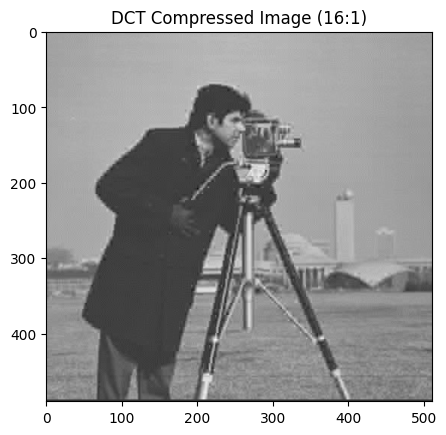

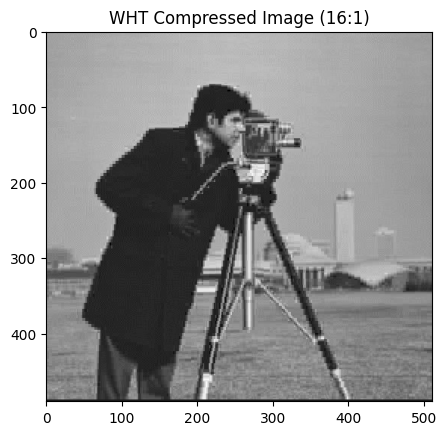

In [30]:
def compress_image(image, block_size, transform, inverse_transform, compression_ratio):
    compressed_image = np.zeros_like(image, dtype=np.float32)
    step = block_size ** 2 // compression_ratio
    
    for i in range(0, 488, block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size]
            transformed_block = transform(block)
            flattened = transformed_block.flatten()
            indices = np.argsort(np.abs(flattened))[-step:]
            compressed_block = np.zeros_like(flattened)
            compressed_block[indices] = flattened[indices]
            
            compressed_block = compressed_block.reshape(8, 8)
            compressed_image[i:i+block_size, j:j+block_size] = inverse_transform(compressed_block)
    
    return compressed_image

block_size = 8
ratios = [4, 8, 16, 32, 64]

compressed_images_dct = []
compressed_images_wht = []

for ratio in ratios:
    compressed_images_dct.append(compress_image(image, block_size, apply_dct, apply_idct, ratio))
    compressed_images_wht.append(compress_image(image, block_size, walsh_hadamard_transform, inverse_walsh_hadamard_transform, ratio))

# Display compressed images for a given ratio, e.g., ratio 16
plt.imshow(compressed_images_dct[2], cmap='gray')
plt.title('DCT Compressed Image (16:1)')
plt.show()

plt.imshow(compressed_images_wht[2], cmap='gray')
plt.title('WHT Compressed Image (16:1)')
plt.show()

DCT Compression Metrics:
           MSE       PSNR      SSIM
4    64.939865  30.005689  0.991913
8    87.834152  28.694170  0.989024
16  143.260178  26.569549  0.981962
32  253.737473  24.086957  0.967585
64  471.761383  21.393580  0.938043

WHT Compression Metrics:
           MSE       PSNR      SSIM
4    78.098595  29.204371  0.990255
8   116.269806  27.476134  0.985413
16  183.010849  25.506035  0.976835
32  285.926971  23.568252  0.963320
64  471.850922  21.392756  0.937976


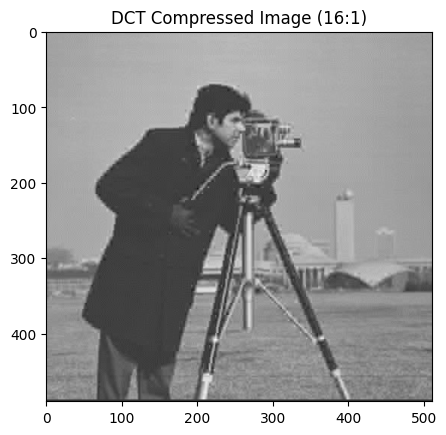

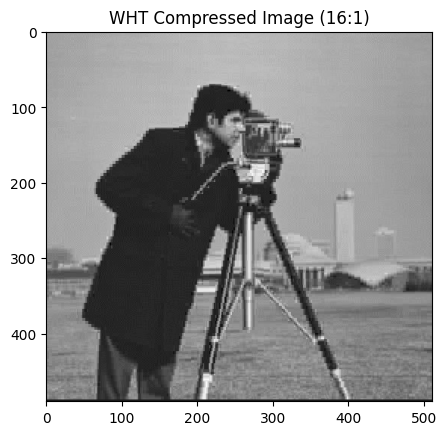

In [39]:
def compute_metrics(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    psnr = 20 * np.log10(255 / np.sqrt(mse))
    ssim = compute_ssim(original, compressed)
    return mse, psnr, ssim

def compute_ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mu1 = img1.mean()
    mu2 = img2.mean()
    sigma1 = img1.std()
    sigma2 = img2.std()
    covariance = np.mean((img1 - mu1) * (img2 - mu2))
    ssim = (2 * mu1 * mu2 + C1) * (2 * covariance + C2) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 ** 2 + sigma2 ** 2 + C2))
    return ssim

block_size = 8
ratios = [4, 8, 16, 32, 64]


compressed_images_dct = []
compressed_images_wht = []
metrics_dct = []
metrics_wht = []

for ratio in ratios:
    compressed_dct = compress_image(image, block_size, apply_dct, apply_idct, ratio)
    compressed_wht = compress_image(image, block_size, walsh_hadamard_transform, inverse_walsh_hadamard_transform, ratio)
    compressed_images_dct.append(compressed_dct)
    compressed_images_wht.append(compressed_wht)
    metrics_dct.append(compute_metrics(image, compressed_dct))
    metrics_wht.append(compute_metrics(image, compressed_wht))

columns = ['MSE', 'PSNR', 'SSIM']

df_dct = pd.DataFrame(metrics_dct, columns=columns, index=ratios)
df_wht = pd.DataFrame(metrics_wht, columns=columns, index=ratios)

print("DCT Compression Metrics:")
print(df_dct)
print("\nWHT Compression Metrics:")
print(df_wht)


plt.imshow(compressed_images_dct[2], cmap='gray')
plt.title('DCT Compressed Image (16:1)')
plt.show()

plt.imshow(compressed_images_wht[2], cmap='gray')
plt.title('WHT Compressed Image (16:1)')
plt.show()

wht is better

In [40]:
class ArithmeticEncoder:
    def __init__(self, precision):
        self.low = 0
        self.high = (1 << precision) - 1
        self.precision = precision
        self.state_size = precision // 2
        self.output = []
        self.mask = (1 << self.state_size) - 1

    def update(self, low_count, high_count, total_count):
        range = self.high - self.low + 1
        self.high = self.low + (range * high_count // total_count) - 1
        self.low = self.low + (range * low_count // total_count)
        
        while True:
            if self.high < (1 << self.state_size):
                self.output_bit(0)
            elif self.low >= (1 << self.state_size):
                self.output_bit(1)
                self.low -= (1 << self.state_size)
                self.high -= (1 << self.state_size)
            elif self.low >= (1 << (self.state_size - 1)) and self.high < (3 << (self.state_size - 1)):
                self.low -= (1 << (self.state_size - 1))
                self.high -= (1 << (self.state_size - 1))
                self.low <<= 1
                self.high = (self.high << 1) + 1

    def output_bit(self, bit):
        self.output.append(bit)

    def finish(self):
        self.output.append(1)

def arithmetic_encode(data, symbols):
    frequency_table = np.bincount(data + symbols, minlength=symbols)
    total_count = len(data)
    encoder = ArithmeticEncoder(32)
    for symbol in data:
        low_count = np.sum(frequency_table[:symbol])
        high_count = low_count + frequency_table[symbol]
        encoder.update(low_count, high_count, total_count)
    encoder.finish()
    return encoder.output

compressed_dct_16 = compressed_images_dct[2]
compressed_flat = compressed_dct_16.flatten().astype(np.int32)


encoded_data = arithmetic_encode(compressed_flat, 256)

print("Arithmetic coding applied to DCT compressed result for 16:1 compression ratio.")

MemoryError: 

Memory Error!!

Q4

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

Text(0.5, 1.0, 'Tiny Stars Isolated')

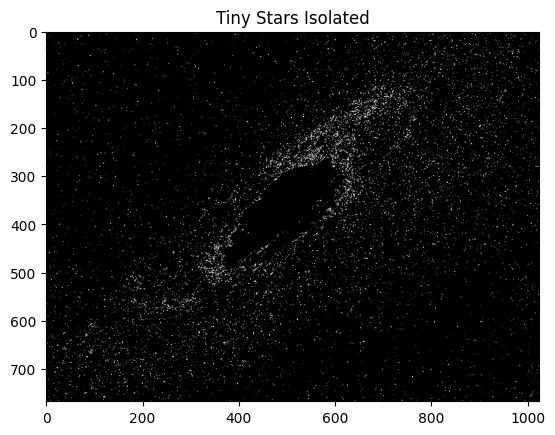

In [143]:

image = Image.open('andromeda-galaxy.png').convert('L')
image = np.array(image)

threshold = 128
_, binary_img = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

structuring_element = np.array([[0, 1, 0],
                                [1, 1, 1],
                                [0, 1, 0]])

def erode(image, se):
    output = np.zeros_like(image)
    pad = se.shape[0] // 2
    padded_image = np.pad(image, pad, mode='constant', constant_values=0)
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            if np.all(padded_image[i-pad:i+pad+1, j-pad:j+pad+1] & se == se):
                output[i-pad, j-pad] = 1
    return output

def dilate(image, se):
    output = np.zeros_like(image)
    pad = se.shape[0] // 2
    padded_image = np.pad(image, pad, mode='constant', constant_values=0)
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            if np.any(padded_image[i-pad:i+pad+1, j-pad:j+pad+1] & se):
                output[i-pad, j-pad] = 1
    return output


eroded_image = erode(binary_img, structuring_element)

tiny_stars = dilate(eroded_image, structuring_element)

plt.imshow(binary_img - 255*tiny_stars , cmap='gray')
plt.title('Tiny Stars Isolated')

# plt.imshow(tiny_stars, cmap='gray')
# plt.title('Tiny Stars')
# plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3116\20020941.py:39: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  labels[current_y, current_x] = label
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3116\20020941.py:39: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 257 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  labels[current_y, current_x] = label
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3116\20020941.py:39: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 258 to uint8 will fail in the future.
For th

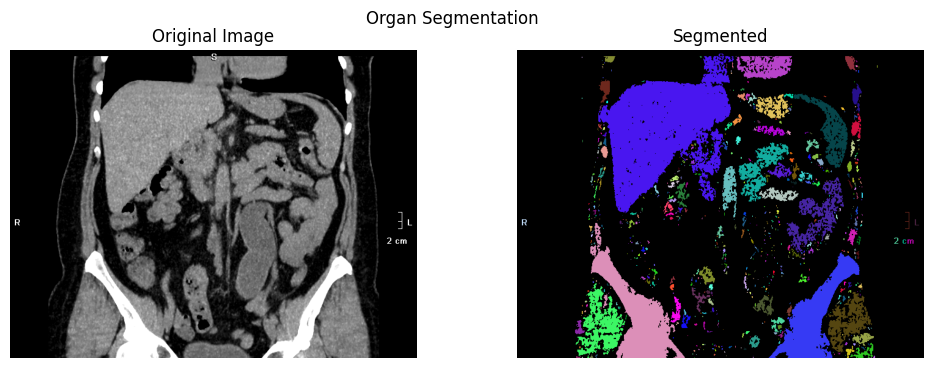

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


image = Image.open('MRI.png').convert('L')
width, height = image.size
pixels = np.array(image)

threshold = 128
binary_image = np.where(pixels < threshold, 0, 255)


structuring_element = np.array([[0, 1, 0],
                               [1, 1, 1],
                               [0, 1, 0]], dtype=np.uint8)

eroded_image = np.zeros((height, width), dtype=np.uint8)
dilated_image = np.zeros((height, width), dtype=np.uint8)

for y in range(1, height - 1):
    for x in range(1, width - 1):
        region = binary_image[y-1:y+2, x-1:x+2]
        eroded_image[y, x] = np.min(region)
        dilated_image[y, x] = np.max(region)

visited = np.zeros((height, width), dtype=np.uint8)
labels = np.zeros((height, width), dtype=np.uint8)
label = 1

for y in range(height):
    for x in range(width):
        if binary_image[y, x] == 255 and visited[y, x] == 0:
            stack = [(x, y)]
            while stack:
                current_x, current_y = stack.pop()
                if visited[current_y, current_x] == 0:
                    visited[current_y, current_x] = 1
                    labels[current_y, current_x] = label
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            new_x = current_x + dx
                            new_y = current_y + dy
                            if 0 <= new_x < width and 0 <= new_y < height:
                                if binary_image[new_y, new_x] == 255 and visited[new_y, new_x] == 0:
                                    stack.append((new_x, new_y))
            label += 1


min_organ_size = 1000  
filtered_image = np.zeros((height, width), dtype=np.uint8)
organ_colors = {}

for l in range(1, label):
    organ_pixels = np.where(labels == l, 255, 0)
    organ_size = np.sum(organ_pixels)
    if organ_size >= min_organ_size:
        organ_id = len(organ_colors) + 1
        filtered_image = np.where(labels == l, organ_id, filtered_image)
        organ_colors[organ_id] = np.random.randint(0, 256, size=3)

reconstructed_image = Image.fromarray(filtered_image.astype(np.uint8))


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Organ Segmentation')


axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# axes[1].imshow(filtered_image, cmap='nipy_spectral')
# axes[1].set_title('Segmented Image')
# axes[1].axis('off')

reconstructed_pixels = np.zeros((height, width, 3), dtype=np.uint8)
for organ_id, color in organ_colors.items():
    reconstructed_pixels[filtered_image == organ_id] = color
axes[1].imshow(reconstructed_pixels)
axes[1].set_title('Segmented')
axes[1].axis('off')

plt.show()

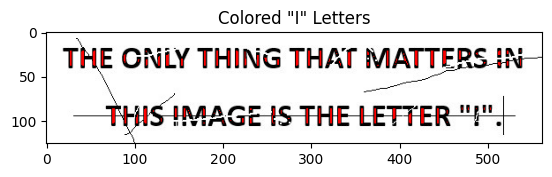

In [126]:
image = Image.open('text.jpg').convert('L')
image = np.array(image)

threshold = 128
binary_image = (image < threshold).astype(np.uint8)

structuring_element = np.zeros((7, 7), np.uint8)
structuring_element[:, 3] = 1 
structuring_element[:, 2] = 1  
structuring_element[:, 4] = 1 
# structuring_element[0, :] = 0

# structuring_element[6, :] = 0




eroded_image = erode(binary_image, structuring_element)

dilated_image = dilate(eroded_image, structuring_element)

colored_image = np.stack([image] * 3, axis=-1)
colored_image[eroded_image == 1] = [255, 0, 0]

plt.imshow(colored_image)
plt.title('Colored "I" Letters')
plt.show()

In [123]:
structuring_element

array([[0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1]], dtype=uint8)